In [1]:
import numpy as np
from pycaret.classification import setup, compare_models

# speedup sklearn
# import dpctl
from sklearnex import patch_sklearn, config_context
patch_sklearn()

import pandas as pd
import torch
from torch import nn
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
import smote_variants as sv

from segmentation import plot_number_of_segments, MLP, plot_heatmap_normalized

# import warnings
# warnings.filterwarnings("ignore")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
data = pd.read_pickle("data/mvnx_merged_data_har_without_null.pkl")
data = data.drop(
        ['gender', 'LeftToe_acc_0', 'LeftToe_acc_1', 'LeftToe_acc_2', 'LeftToe_angular_acc_0', 'LeftToe_angular_acc_1',
         'LeftToe_angular_acc_2', 'LeftToe_vel_0', 'LeftToe_vel_1', 'LeftToe_vel_2', 'LeftToe_angular_vel_0',
         'LeftToe_angular_vel_1', 'LeftToe_angular_vel_2', 'LeftToe_ori_0', 'LeftToe_ori_1', 'LeftToe_ori_2',
         'LeftToe_ori_3', 'LeftToe_pos_0', 'LeftToe_pos_1', 'LeftToe_pos_2'], axis=1)
data.head(1000)

,Pelvis_acc_0,Pelvis_acc_1,Pelvis_acc_2,Pelvis_angular_acc_0,Pelvis_angular_acc_1,Pelvis_angular_acc_2,Pelvis_vel_0,Pelvis_vel_1,Pelvis_vel_2,Pelvis_angular_vel_0,Pelvis_angular_vel_1,Pelvis_angular_vel_2,Pelvis_ori_0,Pelvis_ori_1,Pelvis_ori_2,Pelvis_ori_3,Pelvis_pos_0,Pelvis_pos_1,Pelvis_pos_2,L5_acc_0,L5_acc_1,L5_acc_2,L5_angular_acc_0,L5_angular_acc_1,L5_angular_acc_2,L5_vel_0,L5_vel_1,L5_vel_2,L5_angular_vel_0,L5_angular_vel_1,L5_angular_vel_2,L5_ori_0,L5_ori_1,L5_ori_2,L5_ori_3,L5_pos_0,L5_pos_1,L5_pos_2,L3_acc_0,L3_acc_1,L3_acc_2,L3_angular_acc_0,L3_angular_acc_1,L3_angular_acc_2,L3_vel_0,L3_vel_1,L3_vel_2,L3_angular_vel_0,L3_angular_vel_1,L3_angular_vel_2,L3_ori_0,L3_ori_1,L3_ori_2,L3_ori_3,L3_pos_0,L3_pos_1,L3_pos_2,T12_acc_0,T12_acc_1,T12_acc_2,T12_angular_acc_0,T12_angular_acc_1,T12_angular_acc_2,T12_vel_0,T12_vel_1,T12_vel_2,T12_angular_vel_0,T12_angular_vel_1,T12_angular_vel_2,T12_ori_0,T12_ori_1,T12_ori_2,T12_ori_3,T12_pos_0,T12_pos_1,T12_pos_2,T8_acc_0,T8_acc_1,T8_acc_2,T8_angular_acc_0,T8_angular_acc_1,T8_angular_acc_2,T8_vel_0,T8_vel_1,T8_vel_2,T8_angular_vel_0,T8_angular_vel_1,T8_angular_vel_2,T8_ori_0,T8_ori_1,T8_ori_2,T8_ori_3,T8_pos_0,T8_pos_1,T8_pos_2,Neck_acc_0,Neck_acc_1,Neck_acc_2,Neck_angular_acc_0,Neck_angular_acc_1,Neck_angular_acc_2,Neck_vel_0,Neck_vel_1,Neck_vel_2,Neck_angular_vel_0,Neck_angular_vel_1,Neck_angular_vel_2,Neck_ori_0,Neck_ori_1,Neck_ori_2,Neck_ori_3,Neck_pos_0,Neck_pos_1,Neck_pos_2,Head_acc_0,Head_acc_1,Head_acc_2,Head_angular_acc_0,Head_angular_acc_1,Head_angular_acc_2,Head_vel_0,Head_vel_1,Head_vel_2,Head_angular_vel_0,Head_angular_vel_1,Head_angular_vel_2,Head_ori_0,Head_ori_1,Head_ori_2,Head_ori_3,Head_pos_0,Head_pos_1,Head_pos_2,RightShoulder_acc_0,RightShoulder_acc_1,RightShoulder_acc_2,RightShoulder_angular_acc_0,RightShoulder_angular_acc_1,RightShoulder_angular_acc_2,RightShoulder_vel_0,RightShoulder_vel_1,RightShoulder_vel_2,RightShoulder_angular_vel_0,RightShoulder_angular_vel_1,RightShoulder_angular_vel_2,RightShoulder_ori_0,RightShoulder_ori_1,RightShoulder_ori_2,RightShoulder_ori_3,RightShoulder_pos_0,RightShoulder_pos_1,RightShoulder_pos_2,RightUpperArm_acc_0,RightUpperArm_acc_1,RightUpperArm_acc_2,RightUpperArm_angular_acc_0,RightUpperArm_angular_acc_1,RightUpperArm_angular_acc_2,RightUpperArm_vel_0,RightUpperArm_vel_1,RightUpperArm_vel_2,RightUpperArm_angular_vel_0,RightUpperArm_angular_vel_1,RightUpperArm_angular_vel_2,RightUpperArm_ori_0,RightUpperArm_ori_1,RightUpperArm_ori_2,RightUpperArm_ori_3,RightUpperArm_pos_0,RightUpperArm_pos_1,RightUpperArm_pos_2,RightForeArm_acc_0,RightForeArm_acc_1,RightForeArm_acc_2,RightForeArm_angular_acc_0,RightForeArm_angular_acc_1,RightForeArm_angular_acc_2,RightForeArm_vel_0,RightForeArm_vel_1,RightForeArm_vel_2,RightForeArm_angular_vel_0,RightForeArm_angular_vel_1,RightForeArm_angular_vel_2,RightForeArm_ori_0,RightForeArm_ori_1,RightForeArm_ori_2,RightForeArm_ori_3,RightForeArm_pos_0,RightForeArm_pos_1,RightForeArm_pos_2,RightHand_acc_0,RightHand_acc_1,RightHand_acc_2,RightHand_angular_acc_0,RightHand_angular_acc_1,RightHand_angular_acc_2,RightHand_vel_0,RightHand_vel_1,RightHand_vel_2,RightHand_angular_vel_0,RightHand_angular_vel_1,RightHand_angular_vel_2,RightHand_ori_0,RightHand_ori_1,RightHand_ori_2,RightHand_ori_3,RightHand_pos_0,RightHand_pos_1,RightHand_pos_2,LeftShoulder_acc_0,LeftShoulder_acc_1,LeftShoulder_acc_2,LeftShoulder_angular_acc_0,LeftShoulder_angular_acc_1,LeftShoulder_angular_acc_2,LeftShoulder_vel_0,LeftShoulder_vel_1,LeftShoulder_vel_2,LeftShoulder_angular_vel_0,LeftShoulder_angular_vel_1,LeftShoulder_angular_vel_2,LeftShoulder_ori_0,LeftShoulder_ori_1,LeftShoulder_ori_2,LeftShoulder_ori_3,LeftShoulder_pos_0,LeftShoulder_pos_1,LeftShoulder_pos_2,LeftUpperArm_acc_0,LeftUpperArm_acc_1,LeftUpperArm_acc_2,LeftUpperArm_angular_acc_0,LeftUpperArm_angular_acc_1,LeftUpperArm_angular_acc_2,LeftUpperArm_vel_0,LeftUpperArm_vel_1,LeftUpperArm_vel_2,LeftUpperArm_angular_vel_0,LeftUpperArm_angular_vel_1,LeftUpperArm_angular

## Machine Learning Models with PyCaret

In [3]:
fold_groups = data.key
df = data.drop(columns=["year", "id", "sample", "speed", "key"])
df.head()

,Pelvis_acc_0,Pelvis_acc_1,Pelvis_acc_2,Pelvis_angular_acc_0,Pelvis_angular_acc_1,Pelvis_angular_acc_2,Pelvis_vel_0,Pelvis_vel_1,Pelvis_vel_2,Pelvis_angular_vel_0,Pelvis_angular_vel_1,Pelvis_angular_vel_2,Pelvis_ori_0,Pelvis_ori_1,Pelvis_ori_2,Pelvis_ori_3,Pelvis_pos_0,Pelvis_pos_1,Pelvis_pos_2,L5_acc_0,L5_acc_1,L5_acc_2,L5_angular_acc_0,L5_angular_acc_1,L5_angular_acc_2,L5_vel_0,L5_vel_1,L5_vel_2,L5_angular_vel_0,L5_angular_vel_1,L5_angular_vel_2,L5_ori_0,L5_ori_1,L5_ori_2,L5_ori_3,L5_pos_0,L5_pos_1,L5_pos_2,L3_acc_0,L3_acc_1,L3_acc_2,L3_angular_acc_0,L3_angular_acc_1,L3_angular_acc_2,L3_vel_0,L3_vel_1,L3_vel_2,L3_angular_vel_0,L3_angular_vel_1,L3_angular_vel_2,L3_ori_0,L3_ori_1,L3_ori_2,L3_ori_3,L3_pos_0,L3_pos_1,L3_pos_2,T12_acc_0,T12_acc_1,T12_acc_2,T12_angular_acc_0,T12_angular_acc_1,T12_angular_acc_2,T12_vel_0,T12_vel_1,T12_vel_2,T12_angular_vel_0,T12_angular_vel_1,T12_angular_vel_2,T12_ori_0,T12_ori_1,T12_ori_2,T12_ori_3,T12_pos_0,T12_pos_1,T12_pos_2,T8_acc_0,T8_acc_1,T8_acc_2,T8_angular_acc_0,T8_angular_acc_1,T8_angular_acc_2,T8_vel_0,T8_vel_1,T8_vel_2,T8_angular_vel_0,T8_angular_vel_1,T8_angular_vel_2,T8_ori_0,T8_ori_1,T8_ori_2,T8_ori_3,T8_pos_0,T8_pos_1,T8_pos_2,Neck_acc_0,Neck_acc_1,Neck_acc_2,Neck_angular_acc_0,Neck_angular_acc_1,Neck_angular_acc_2,Neck_vel_0,Neck_vel_1,Neck_vel_2,Neck_angular_vel_0,Neck_angular_vel_1,Neck_angular_vel_2,Neck_ori_0,Neck_ori_1,Neck_ori_2,Neck_ori_3,Neck_pos_0,Neck_pos_1,Neck_pos_2,Head_acc_0,Head_acc_1,Head_acc_2,Head_angular_acc_0,Head_angular_acc_1,Head_angular_acc_2,Head_vel_0,Head_vel_1,Head_vel_2,Head_angular_vel_0,Head_angular_vel_1,Head_angular_vel_2,Head_ori_0,Head_ori_1,Head_ori_2,Head_ori_3,Head_pos_0,Head_pos_1,Head_pos_2,RightShoulder_acc_0,RightShoulder_acc_1,RightShoulder_acc_2,RightShoulder_angular_acc_0,RightShoulder_angular_acc_1,RightShoulder_angular_acc_2,RightShoulder_vel_0,RightShoulder_vel_1,RightShoulder_vel_2,RightShoulder_angular_vel_0,RightShoulder_angular_vel_1,RightShoulder_angular_vel_2,RightShoulder_ori_0,RightShoulder_ori_1,RightShoulder_ori_2,RightShoulder_ori_3,RightShoulder_pos_0,RightShoulder_pos_1,RightShoulder_pos_2,RightUpperArm_acc_0,RightUpperArm_acc_1,RightUpperArm_acc_2,RightUpperArm_angular_acc_0,RightUpperArm_angular_acc_1,RightUpperArm_angular_acc_2,RightUpperArm_vel_0,RightUpperArm_vel_1,RightUpperArm_vel_2,RightUpperArm_angular_vel_0,RightUpperArm_angular_vel_1,RightUpperArm_angular_vel_2,RightUpperArm_ori_0,RightUpperArm_ori_1,RightUpperArm_ori_2,RightUpperArm_ori_3,RightUpperArm_pos_0,RightUpperArm_pos_1,RightUpperArm_pos_2,RightForeArm_acc_0,RightForeArm_acc_1,RightForeArm_acc_2,RightForeArm_angular_acc_0,RightForeArm_angular_acc_1,RightForeArm_angular_acc_2,RightForeArm_vel_0,RightForeArm_vel_1,RightForeArm_vel_2,RightForeArm_angular_vel_0,RightForeArm_angular_vel_1,RightForeArm_angular_vel_2,RightForeArm_ori_0,RightForeArm_ori_1,RightForeArm_ori_2,RightForeArm_ori_3,RightForeArm_pos_0,RightForeArm_pos_1,RightForeArm_pos_2,RightHand_acc_0,RightHand_acc_1,RightHand_acc_2,RightHand_angular_acc_0,RightHand_angular_acc_1,RightHand_angular_acc_2,RightHand_vel_0,RightHand_vel_1,RightHand_vel_2,RightHand_angular_vel_0,RightHand_angular_vel_1,RightHand_angular_vel_2,RightHand_ori_0,RightHand_ori_1,RightHand_ori_2,RightHand_ori_3,RightHand_pos_0,RightHand_pos_1,RightHand_pos_2,LeftShoulder_acc_0,LeftShoulder_acc_1,LeftShoulder_acc_2,LeftShoulder_angular_acc_0,LeftShoulder_angular_acc_1,LeftShoulder_angular_acc_2,LeftShoulder_vel_0,LeftShoulder_vel_1,LeftShoulder_vel_2,LeftShoulder_angular_vel_0,LeftShoulder_angular_vel_1,LeftShoulder_angular_vel_2,LeftShoulder_ori_0,LeftShoulder_ori_1,LeftShoulder_ori_2,LeftShoulder_ori_3,LeftShoulder_pos_0,LeftShoulder_pos_1,LeftShoulder_pos_2,LeftUpperArm_acc_0,LeftUpperArm_acc_1,LeftUpperArm_acc_2,LeftUpperArm_angular_acc_0,LeftUpperArm_angular_acc_1,LeftUpperArm_angular_acc_2,LeftUpperArm_vel_0,LeftUpperArm_vel_1,LeftUpperArm_vel_2,LeftUpperArm_angular_vel_0,LeftUpperArm_angular_vel_1,LeftUpperArm_angular

In [4]:
model = setup(data = df, target = 'segment', session_id=123, fold_strategy='groupkfold', fold=3,  fold_groups=fold_groups, normalize=True,
              normalize_method='minmax', remove_multicollinearity = True, multicollinearity_threshold = 0.6, feature_selection = True, fix_imbalance=True)

,Description,Value
0,session_id,123
1,Target,segment
2,Target Type,Multiclass
3,Label Encoded,"T2: 0, T3: 1, T4: 2, T5: 3"
4,Original Data,"(140754, 420)"
5,Missing Values,False
6,Numeric Features,419
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='segment',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_stra...
                 Advanced_Feature_Selection_Classic(ml_usecase='classification',
                                                    n_jobs=-1, random_state=123,
            

In [5]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.4374,0.5254,0.2689,0.6583,0.2831,0.0282,0.1054,55.1333
dummy,Dummy Classifier,0.4247,0.5000,0.2500,0.1804,0.2532,0.0000,0.0000,64.6800
ridge,Ridge Classifier,0.4236,0.0000,0.2559,0.4127,0.2671,0.0075,0.0245,46.3900
lr,Logistic Regression,0.3963,0.5105,0.2568,0.4333,0.2409,0.0090,0.0312,49.8233
lda,Linear Discriminant Analysis,0.3276,0.5102,0.2574,0.4607,0.1957,0.0079,0.0302,54.7500
svm,SVM - Linear Kernel,0.1971,0.0000,0.2548,0.5414,0.0885,0.0055,0.0329,47.3300
et,Extra Trees Classifier,0.1535,0.5294,0.2736,0.8557,0.0828,0.0240,0.1060,57.1033
lightgbm,Light Gradient Boosting Machine,0.1534,0.5292,0.2731,0.8504,0.0827,0.0237,0.1045,69.5200
rf,Random Forest Classifier,0.1530,0.5276,0.2729,0.8436,0.0822,0.0233,0.1027,47.5133
gbc,Gradient Boosting Classifier,0.1515,0.5265,0.2713,0.8156,0.0794,0.0218,0.0964,106.7433


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')
INFO:logs:compare_models() succesfully completed......................................


## Deep Learning Models

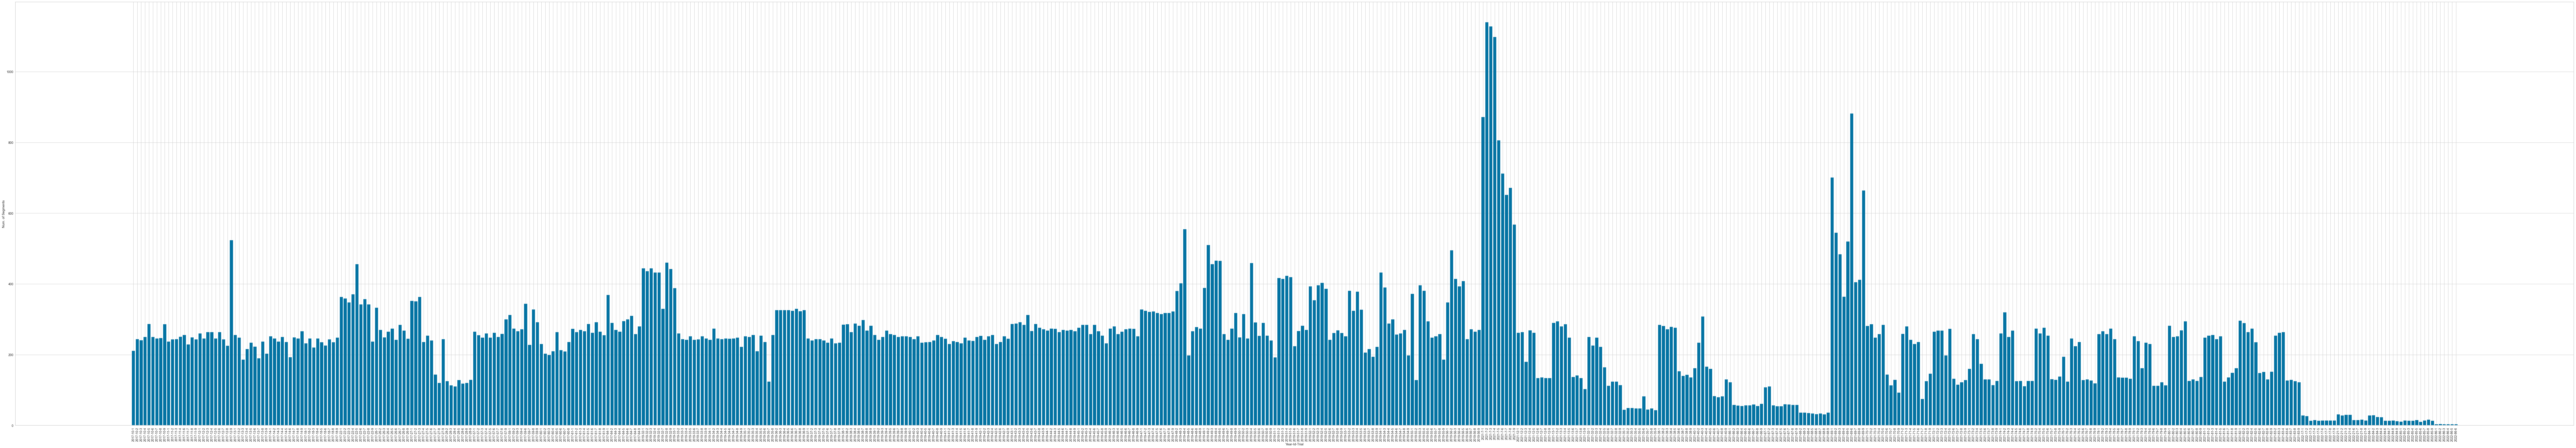

In [7]:
class_names = ["T2", "T3", "T4", "T5"]
segments = data.loc[data["segment"].isin(class_names)]
plot_number_of_segments(segments)

In [8]:
data.segment.value_counts()

T2    59844
T5    48043
T4    17825
T3    15042
Name: segment, dtype: int64

(array([59844.,     0.,     0., 15042.,     0.,     0., 17825.,     0.,
            0., 48043.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

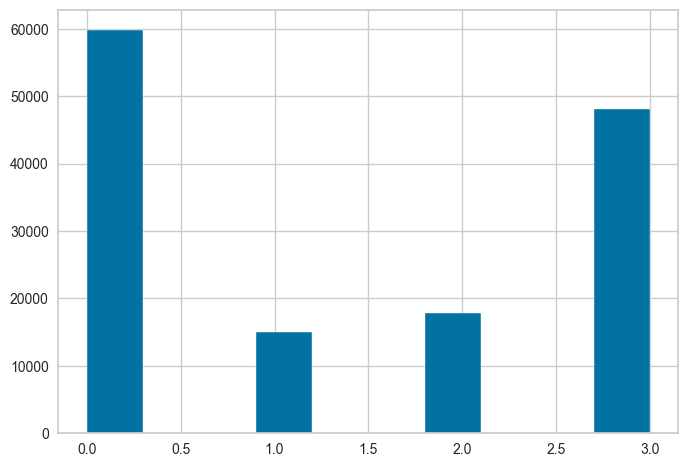

In [9]:
le = LabelEncoder()
le.fit(segments["segment"])
integer_encoded = le.transform(segments["segment"])
plt.hist(integer_encoded)

In [10]:
# "time", "year", "id", "sample", "speed", "key", "segment"
X_train, X_test, y_train, y_test = train_test_split(
    segments[segments.columns.difference(["year", "id", "sample", "speed", "key", "segment"])],
    OneHotEncoder(sparse=False).fit_transform(integer_encoded.reshape(len(integer_encoded), 1)),
    random_state=0,
    shuffle=False,
    test_size=0.1
)

# clf = RandomForestClassifier(n_jobs=-1)
# clf.fit(X_train, y_train)
# pred = clf.predict(X_test)
# score = f1_score(y_test, pred, average="micro")
# print(f"F1: {score}")


In [11]:
for index in range(4):
    _, counts = np.unique(y_train[:, index], return_counts=True)
    print("------------ Label {}: {} ------------".format(index, counts[1]))

    # print("Unique Counts for 0 and 1: {}".format(counts))

------------ Label 0: 53843 ------------
------------ Label 1: 13570 ------------
------------ Label 2: 15713 ------------
------------ Label 3: 43552 ------------


In [9]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
print(device)

X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float).to(device)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train).to(device)
y_test_tensor = np.argmax(y_test, axis=1)

net = MLP(X_train_tensor.size(dim=1), [30], len(le.classes_)).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

for epoch in tqdm(range(0, 5000)):
    current_loss = 0.0
    optimizer.zero_grad()
    out = net(X_train_tensor)
    loss = loss_function(out, y_train_tensor)
    loss.backward()
    optimizer.step()
    current_loss += loss.item()

pred = np.argmax(net(X_test_tensor).to("cpu").detach().numpy(), axis=1)
score = f1_score(y_test_tensor, pred, average="micro")
print(f"F1: {score}")

cuda:0


100%|██████████| 5000/5000 [00:33<00:00, 148.15it/s]

F1: 0.6605569764137539


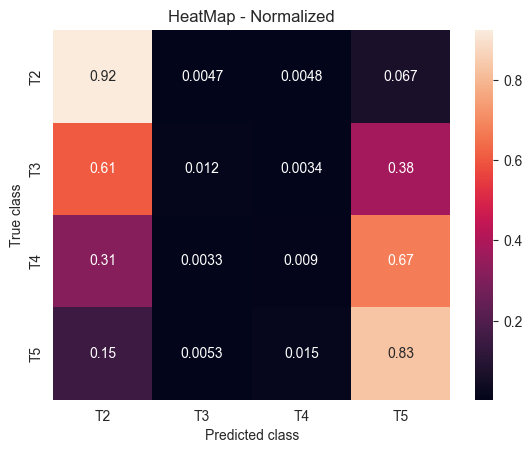

In [11]:
plot_heatmap_normalized(y_test_tensor, pred, class_names)

**Summary:** We notice that for classes T3 and T4 (minority classes) the model has difficulties differentiating and assigns them to T2 or T5 (majority classes) indicating a problem with class imbalance that affects learning. Hence, as a next step, we're fixing the imbalance.

## Handling imbalanced Data

In [12]:
X_train

,Head_acc_0,Head_acc_1,Head_acc_2,Head_angular_acc_0,Head_angular_acc_1,Head_angular_acc_2,Head_angular_vel_0,Head_angular_vel_1,Head_angular_vel_2,Head_ori_0,...,T8_ori_1,T8_ori_2,T8_ori_3,T8_pos_0,T8_pos_1,T8_pos_2,T8_vel_0,T8_vel_1,T8_vel_2,time
0,-0.210661,-0.024053,0.282337,0.254925,0.660982,2.386033,0.071416,0.036322,0.001785,0.730549,...,-0.236600,-0.394306,0.324984,1.737219,8.748377,1.356021,0.013220,-0.001873,-0.001936,350
1,-0.106649,-0.010378,0.284532,0.047667,0.361616,3.088291,0.071615,0.037829,0.014653,0.730525,...,-0.236563,-0.394337,0.324979,1.737264,8.748347,1.356017,0.013279,-0.001824,-0.002437,354
2,-0.105907,0.016027,0.140092,-0.192565,0.152263,0.927757,0.070812,0.038464,0.018518,0.730505,...,-0.236530,-0.394371,0.324988,1.737309,8.748319,1.356011,0.012617,-0.002782,-0.002499,359
3,-0.126325,-0.235177,0.093989,-2.797122,-0.016251,0.417386,0.059158,0.038396,0.020257,0.730490,...,-0.236505,-0.394407,0.325003,1.737356,8.748289,1.356004,0.012455,-0.003299,-0.003065,363
4,-0.107568,-0.047934,-0.003036,-1.838620,0.202449,0.786236,0.051497,0.039239,0.023533,0.730467,...,-0.236487,-0.394444,0.324990,1.737406,8.748257,1.355995,0.012022,-0.003798,-0.002840,367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126673,-1.047541,0.851872,0.377779,2.021887,0.518082,1.147434,0.110192,-0.084011,-0.128602,0.563723,...,0.520511,0.229604,-0.612169,-1.694746,-1.843117,1.347069,0.107155,-0.087709,0.060855,725
126674,-1.581066,0.727333,0.484070,2.832761,2.729443,2.933863,0.121995,-0.072638,-0.116378,0.563506,...,0.520160,0.229744,-0.611841,-1.694161,-1.843623,1.347254,0.101507,-0.083753,0.056384,729
126675,-1.719590,0.328375,0.522458,0.880508,3.793849,6.825000,0.125664,-0.056830,-0.087940,0.563296,...,0.519799,0.229857,-0.611523,-1.693590,-1.844125,1.347436,0.095945,-0.079859,0.052008,733
126676,-2.113630,-0.021037,0.530140,-0.547412,6.621822,6.891421,0.123383,-0.029239,-0.059226,0.563105,...,0.519430,0.229943,-0.611217,-1.693035,-1.844623,1.347615,0.090614,-0.076186,0.047861,737


In [13]:
# scale data
# scaler = MinMaxScaler()
# transform data
# X_train = scaler.fit_transform(X_train)

In [22]:
# data oversample minority class
# sampling_strategy={1: 35000, 2: 35000},
oversample = SMOTE(random_state=1)
X_resampled, y_resampled = oversample.fit_resample(X_train, y_train)

In [23]:
for index in range(4):
    _, counts = np.unique(y_resampled[:, index], return_counts=True)
    print("------------ Label {}: {} ------------".format(index, counts[1]))

------------ Label 0: 53843 ------------
------------ Label 1: 53843 ------------
------------ Label 2: 53843 ------------
------------ Label 3: 53843 ------------


In [24]:
# alternative library
# oversampler= sv.MulticlassOversampling(sv.distance_SMOTE)
# X_samp, y_samp= oversampler.sample(X_train, y_train)

In [25]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
print(device)

X_train_tensor = torch.tensor(X_resampled, dtype=torch.float).to(device)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_resampled.astype(float)).to(device)
y_test_tensor = np.argmax(y_test, axis=1)

net = MLP(X_train_tensor.size(dim=1), [30], len(le.classes_)).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

for epoch in tqdm(range(0, 5000)):
    current_loss = 0.0
    optimizer.zero_grad()
    out = net(X_train_tensor)
    loss = loss_function(out, y_train_tensor)
    loss.backward()
    optimizer.step()
    current_loss += loss.item()

pred = np.argmax(net(X_test_tensor).to("cpu").detach().numpy(), axis=1)
score = f1_score(y_test_tensor, pred, average="micro")
print(f"F1: {score}")

cuda:0


100%|██████████| 5000/5000 [00:50<00:00, 99.98it/s] 

F1: 0.1503267973856209


In [26]:
plot_heatmap_normalized(y_test, pred, class_names)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets